# XROMS Vertical Sections

This notebook demonstrates how to set up and examine arbitrary vertical sections
in ROMS' datasets. The section may be quite general, defined by a set of vertices in
grid coordinates ($\xi$, $\eta$). It may be non-straight and/or non-equidistant.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import xroms

## Set up ROMS dataset

More information at in [load_data notebook](load_data.ipynb)

In [2]:
loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/forecast_latest/txla2_his_f_latest.nc'
chunks = {'ocean_time':1}
ds = xr.open_dataset(loc, chunks=chunks)
ds, grid = xroms.roms_dataset(ds)


## Define a section

The plotting notebook shows how to make a horizontal map with cartopy. Using a map 
of the bottom topography, a straight equidistant section approximately normal to the
isobaths is selected by trial and error. 


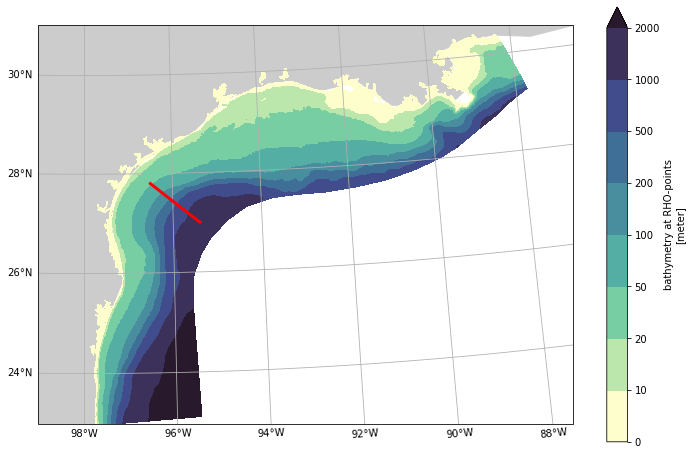

In [3]:
# Map set-up
proj = cartopy.crs.LambertConformal(central_longitude=-98, central_latitude=30)
pc = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=proj)
ax.set_extent([-99, -87.5, 23, 30.5], crs=pc)
ax.add_feature(cartopy.feature.LAND.with_scale('110m'), facecolor='0.8')
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, 
                  xlocs=np.arange(-98,-86,2), ylocs=np.arange(24, 32,2))
gl.top_labels = False
gl.right_labels = False

# Add the topography
levels=[0, 10, 20, 50, 100, 200, 500, 1000, 2000]
H = ds.h.where(ds.mask_rho > 0)
H.plot.contourf(ax=ax, x='lon_rho', y='lat_rho', levels=levels, 
                cmap=cmo.deep, transform=pc)

# Add the section
lon = np.linspace(-96.5, -95.4, 101)
lat = np.linspace(27.8, 27.0, 101)
plt.plot(lon, lat, 'r', lw=3, transform=pc);

## Convert to ROMS grid coordinates

A function `ll2xy` converts from lon/lat to ROMS grid coordinates ($\xi$, $\eta$)
using scipy's griddata function. The inverse `xy2ll` is simpler, 
using xarray's interp function.

In [4]:
X, Y = xroms.ll2xy(ds, lon, lat)

## The section dataset

The section function defines an xarray Dataset containing (nearly) all variables from
the ROMS dataset. It is defined on a staggered 2D coordinate system, with 
horizontal dimension `distance` and `s_rho` as vertical coordinates. A xgcm grid is
also returned, useful for generating quantitative data from the section..


In [5]:
# Få bedre navn enn grids
dss, grids = xroms.section(ds.isel(ocean_time=0), X, Y)

## Plot the section

A variable along the section can be plotted by using `z_rho` as vertical coordinate.
Several choices are possible for the horizontal coordinate. The horizontal dimension
`distance` may be the obvious choice.

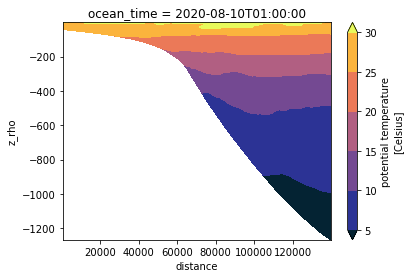

In [6]:
levels = np.arange(5, 35, 5)
dss.temp.plot.contourf('distance', 'z_rho', levels=levels, cmap=cmo.thermal);

## Plotting hydrography

The purpose of this cell is to provide a nicer view of the hydrography along the 
section. We define a new vertical coordinate `depth` which have positive values.
A new horizontal coordinate `dist` provide distance in km, which gives nicer numbers.
Using `long_name` and `units` attributes of the coordinate variables give control ocer
the axis labels.

The depth range is limited to 400 m to show more details in the upper layer.

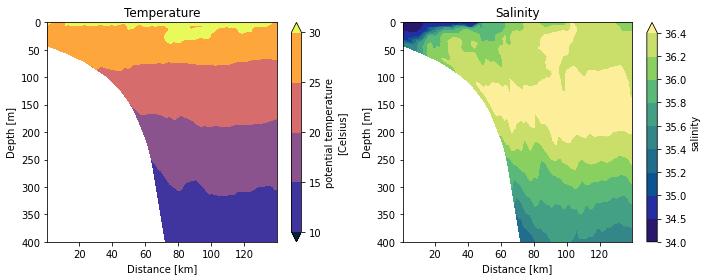

In [7]:
# New coordinates
dss.coords["depth"] = -dss.z_rho
dss.depth.attrs = {'long_name':'Depth', 'units': 'm'}
dss.coords["dist"] = dss.distance * 1e-3
dss.dist.attrs = {'long_name': 'Distance', 'units': 'km'}

# Plot
plt.figure(figsize=(10,4))
# Temperature
plt.subplot(1,2,1)
levels = np.arange(10, 35, 5)
dss.temp.plot.contourf('dist', 'depth', ylim=(400, 0), levels=levels, cmap=cmo.thermal)
plt.title("Temperature")
# Salinity
plt.subplot(1,2,2)
levels = [34, 34.5, 35, 35.2, 35.4, 35.6, 35.8, 36, 36.2, 36.4]
dss.salt.plot.contourf('dist', 'depth', ylim=(400, 0), levels=levels, cmap=cmo.haline)
plt.title("Salinity")

plt.tight_layout()

## Current

The section dataset provide the normal and tangential current along the section.
The sign convention is that tangential current is positive in the direction of increasing distance, and the tangential and normal current is forms a right hand 
system. 

In the plot below, the positive red Gulf stream goes towards northeast. 
On the shelf there is a counterflow towards southwest.

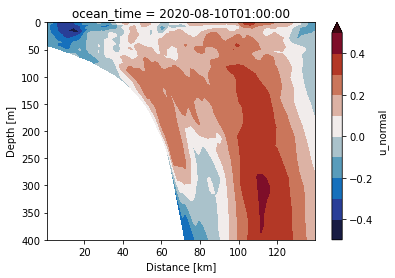

In [8]:
# Choose symmetric speed levels around zero and plot the normal current
levels = np.arange(-0.5, 0.6, 0.1)
dss.u_normal.plot.contourf('dist', 'depth', ylim=(400, 0), levels=levels, cmap=cmo.balance);

## Section metrics

Some geographical characteristics of the section is easily computed.
The `xgcm` Grid object is not essential but simplifies the notation.
The vertical and horisontal axes are noted `Z` and `L` respectively.

Without `xgcm` the mean depth can be calculated as
```python
    mean_depth = np.sum(dss.h * dss.ddistance) / np.sum(dss.ddistance)
```

In [9]:
length = np.sum(dss.ddistance)
mean_depth = grids.average(dss.h, axis='L')
max_depth = dss.h.max()
area = grids.integrate(dss.h, axis='L')   # Undisturbed area

print(f"Length        =  {float(length)*1e-3:.2f} km")
print(f"Mean depth    =  {float(mean_depth):.2f} m")
print(f"Maximum depth = {float(max_depth):.2f} m")
print(f"Area          =   {float(area)*1e-6:.2f} km²")

Length        =  140.52 km
Mean depth    =  534.26 m
Maximum depth = 1356.77 m
Area          =   75.07 km²


## Flux calculations

Integrating quantities based on the normal current gives quantitative
flux estimates. These estimates may depend on the number of points along
the section. 

For more robust flux estimates, a "staircase" section object
following the horizontal grid cell structure in ROMS may be better. This
has the advantage of using ROMS flux values without any interpolation.
This is presently not available in `xroms`.

In [10]:
LZ = ('L', 'Z')
totflux = grids.integrate(dss.u_normal, LZ)
northflux = grids.integrate(dss.u_normal.where(dss.u_normal > 0), LZ)
southflux = -grids.integrate(dss.u_normal.where(dss.u_normal < 0), LZ)

print(f"Net volume flux        = {float(totflux)*1e-6:.1f} Sv")
print(f"Northwards volume flux = {float(northflux)*1e-6:.1f} Sv")
print(f"Southwards volume flux =  {float(southflux)*1e-6:.1f} Sv")


Net volume flux        = 10.1 Sv
Northwards volume flux = 12.6 Sv
Southwards volume flux =  2.5 Sv


## Flux series

Using the total time dependent dataset it is possible to estimate
the time series of flux through the section. With a remote dataset,
this may take some time as data from every time step has to be downloaded
and read into computer memory.

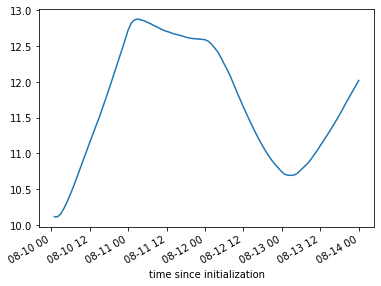

In [11]:
dss_tot, grids_tot = xroms.section(ds, X, Y)
totflux_series = grids_tot.integrate(dss_tot.u_normal, LZ) * 1e-6
totflux_series.plot();